<a href="https://colab.research.google.com/github/baicheto/AML_Bitcoin/blob/Kri/AML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anti-Money Launderig - Elliptic dataset**
- The dataset is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.
- The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.



In [57]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/AML/elliptic_bitcoin_dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
pip install torch_geometric

In [59]:


import os

import numpy as np
import pandas as pd
import random
import torch
import torch_geometric
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F


from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


#### 1. Read the files

In [60]:
features = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
edges = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
classes = pd.read_csv('/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')


In [61]:
trans_features = ["trans_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + trans_features + agg_features

print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")


Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [62]:
features.head()

,txId,time_step,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,agg_feat_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [63]:
edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [64]:
classes.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


Map the illicit, licit, unknown transactions to 1, 2 and 0 respectively

In [87]:
#classes['class'] = classes['class'].replace({'unknown': 0, '1': 1, '2': 2})
classes['class'] = classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * classes['class'].value_counts(normalize=True), 2)
class_counts = classes['class'].value_counts()

In [66]:
classes

,txId,class,class_mapped
0,230425980,unknown,unknown
1,5530458,unknown,unknown
2,232022460,unknown,unknown
3,232438397,2,licit
4,230460314,unknown,unknown
...,...,...,...
203764,173077460,unknown,unknown
203765,158577750,unknown,unknown
203766,158375402,1,illicit
203767,158654197,unknown,unknown


In [67]:
classes_df = classes[['txId', 'class']].copy()
classes_df['Percentage'] = classes_df['class'].map(percentage_distribution)
classes_df['Counts'] = classes_df['class'].map(class_counts)

In [68]:
classes_df

,txId,class,Percentage,Counts
0,230425980,unknown,77.15,157205
1,5530458,unknown,77.15,157205
2,232022460,unknown,77.15,157205
3,232438397,2,20.62,42019
4,230460314,unknown,77.15,157205
...,...,...,...,...
203764,173077460,unknown,77.15,157205
203765,158577750,unknown,77.15,157205
203766,158375402,1,2.23,4545
203767,158654197,unknown,77.15,157205


**EDA**

Let's create a NetworkX graph G from the edge list, where:

Each node is a Bitcoin transaction (txId1, txId2).

Each edge represents a transaction flow between two transactions (a directed connection in practice)

In [69]:
# Let's create a graph
G = nx.from_pandas_edgelist(edges, 'txId1', 'txId2')

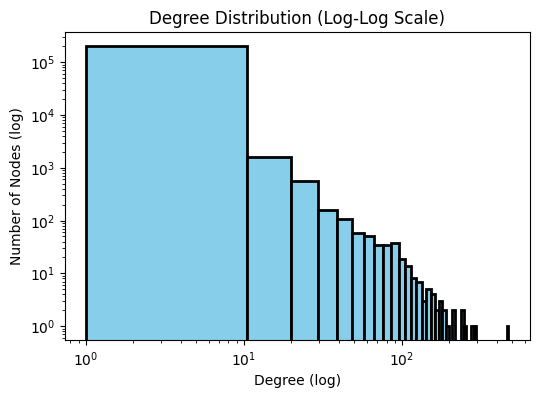

In [70]:
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

This graph shows that the network has a heavy-tailed degree distribution.

A few transactions interact with many others — potential hubs.

Most transactions interact with very few others.

The results are pretty common for financial-transaction graphs

In [71]:
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

Number of connected components: 49


In [72]:
# Giant component analysis (largest connected cluster)
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


**Node centrality measures**

Degree centrality
- measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

In [73]:

# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

# Subgraph of top nodes
top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)

# Get node colors based on centrality
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
cmap = plt.cm.cool

# Create scalar mappable for the colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


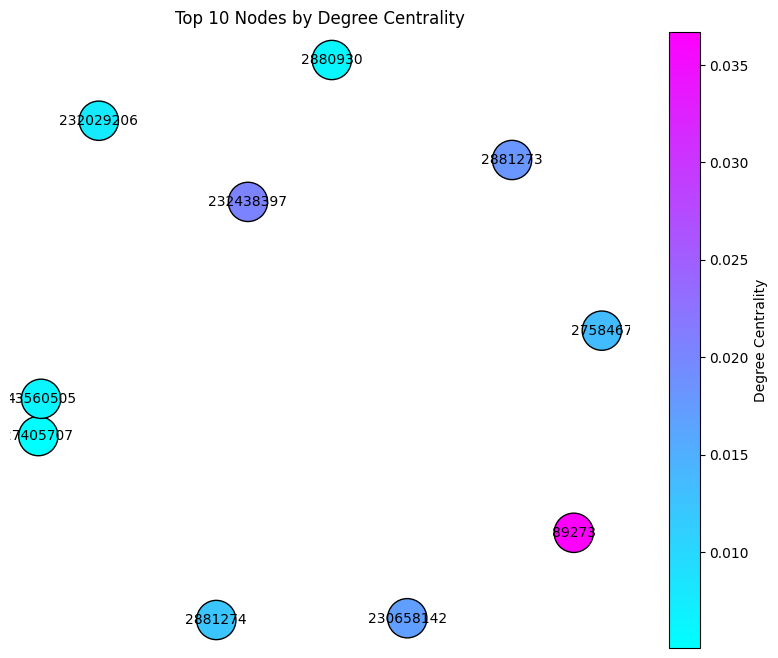

In [74]:
# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color=node_color, cmap=cmap, node_size=800, edgecolors='black')
nx.draw_networkx_edges(subgraph, pos)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.colorbar(sm, label='Degree Centrality', ax=plt.gca())
plt.title('Top 10 Nodes by Degree Centrality')
plt.axis('off')
plt.show()


2. Betweeness Centrality
- Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

- A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

In [75]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


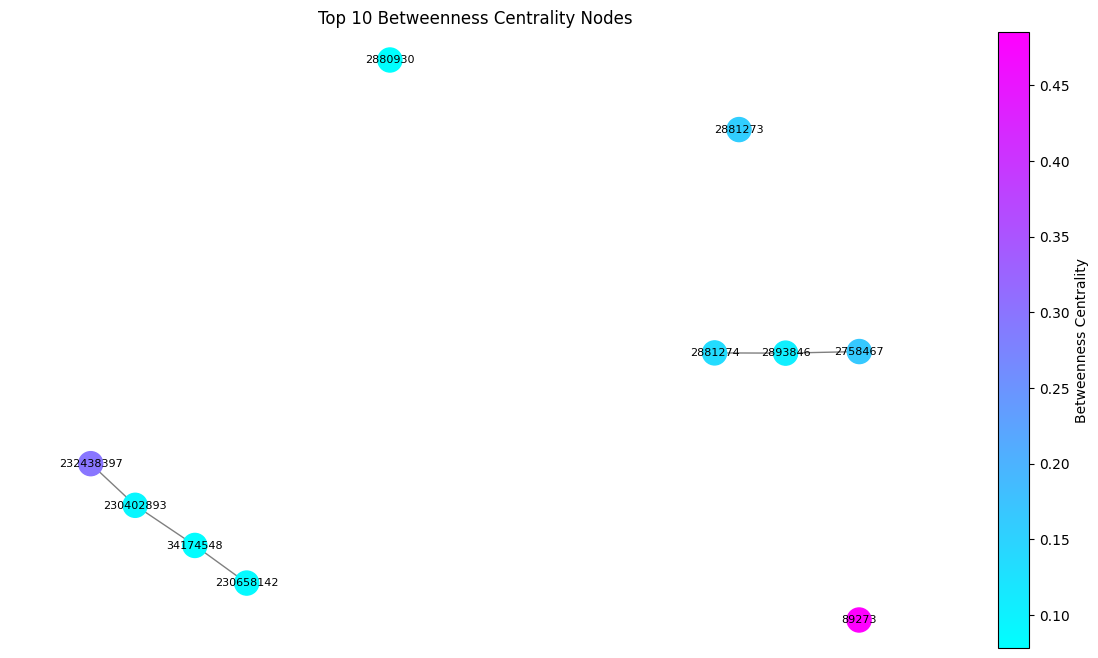

In [76]:
fig, ax = plt.subplots(figsize=(15, 8))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(subgraph, pos,
                               node_color=node_color,
                               cmap=cmap,
                               node_size=300,
                               ax=ax)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Betweenness Centrality')

ax.set_title('Top 10 Betweenness Centrality Nodes')
ax.axis('off')
plt.show()

3. Closeness Centrality
- Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.
-  A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

In [77]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool


Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


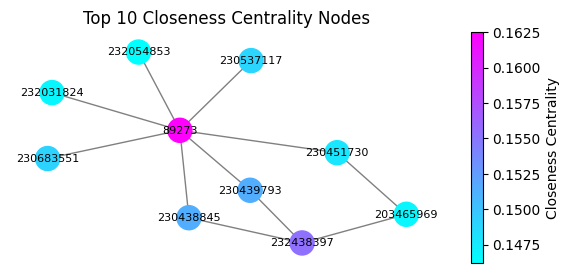

In [78]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = nx.spring_layout(subgraph, seed=42)

nodes = nx.draw_networkx_nodes(
    subgraph, pos,
    node_color=node_color,
    cmap=cmap,
    node_size=300,
    ax=ax
)
nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

# Create colorbar from scalar mappable
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Closeness Centrality')

ax.set_title('Top 10 Closeness Centrality Nodes')
ax.axis('off')
plt.show()

**Class-specific analysis**

In [88]:
# Class-based subgraphs.
#illicit_nodes = classes_df[classes_df['class'] == 1]['txId']
#licit_nodes = classes_df[classes_df['class'] == 2]['txId']
illicit_nodes = classes_df[classes_df['class'] == 'illicit']['txId']
licit_nodes = classes_df[classes_df['class'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

Text(0.5, 1.0, 'Illicit Transactions Subgraph')

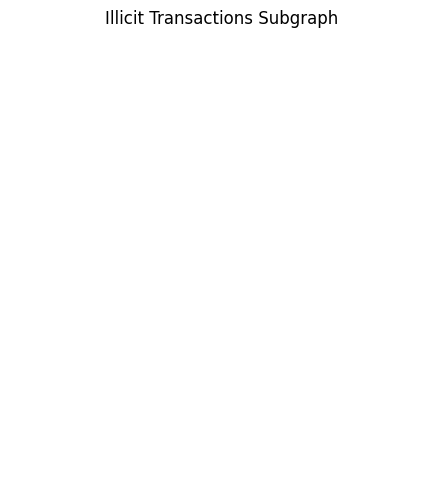

In [89]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')


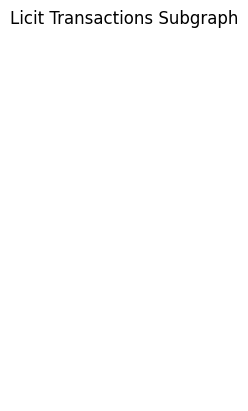

In [86]:

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

TODO:
- explore the 89273 node (show whether it is illicit, licit, unknown)
- merge features with classes
- sort tx_idx for classes and edges
- ML classify only with the transaction features and only with the aggregated ones -> compare the results ? if enough time
- For Node2Vec use (trans, agg and all features -> compare results)
- Use GIN with (trans, agg and all features -> compare results)
- Apply Deep Neural Decision Forest (suggested by prof paper) ? if enough time

In [82]:
class_values = sorted(classes["class"].unique())

In [83]:
tx_idx = {name: idx for idx, name in enumerate(sorted(classes["txId"].unique()))}

In [84]:
classes["txId"] = classes["txId"].apply(lambda name: tx_idx[name])